In [1]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import svmbir
import ast
from pprint import pprint
# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 256


# Workflow starts here!

In [2]:
###################### need to change start
ipts="34139"
###################### need to change end

In [3]:
# hdf5_loc = "/netdisk/y9z/IPTS-"+ipts+"/hdf5/"
hdf5_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
sorted(os.listdir(hdf5_loc))

['2025_03_05_Tube1_766proj_gridrec.h5',
 '2025_03_05_Tube2_764proj_gridrec.h5',
 '2025_03_06_Tube3_970proj_gridrec.h5',
 '2025_03_06_Tube4_766proj_gridrec.h5',
 '2025_03_06_Tube5_734proj_gridrec.h5',
 '2025_03_07_Tube6_734proj_gridrec.h5']

In [10]:
###################### need to change start
sample_name = "2025_03_07_Tube6_734proj_gridrec"
hdf5 = hdf5_loc + sample_name + ".h5"
###################### need to change end
instrument = "/HFIR/CG1D"
svmbir_path = instrument + "/IPTS-"+ipts+"/shared/autoreduce/svmbir/"

# Load hdf5 file

In [5]:
losa.get_hdf_tree(hdf5)
history_dict_str = losa.load_hdf(hdf5, key_path='tomo/recon/history')[0]
history_dict = ast.literal_eval(history_dict_str.decode("utf-8"))
pprint(history_dict)
#########################
proj_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/proj/proj_mlog_to_recon')
# sino_mlog = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog')
sino_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog_to_recon')
ang_deg = losa.load_hdf(hdf5, key_path='tomo/info/ang_deg')
ang_rad = losa.load_hdf(hdf5, key_path='tomo/info/ang_rad')
proj000_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj000_idx')[0]
proj180_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj180_idx')[0]
proj360_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj360_idx')[0]
rot_center_used = history_dict['rot_center']
rot_center_180 = history_dict['rot_center_180']
rot_center_360 = history_dict['rot_center_360']
pixel_size_um = history_dict['pixel_size_um']
gamma_diff = history_dict['gamma_diff']
# recon_hdf5 = losa.load_hdf(hdf5, key_path='tomo/recon/recon_volume')
if history_dict['recon_crop']:
    recon_crop = True
    recon_crop_left = history_dict['recon_crop_roi']['left']
    recon_crop_right = history_dict['recon_crop_roi']['right']
    recon_crop_top = history_dict['recon_crop_roi']['top']
    recon_crop_bottom = history_dict['recon_crop_roi']['bottom']
else:
    recon_crop = False
    recon_crop_left = None
    recon_crop_right = None
    recon_crop_top = None
    recon_crop_bottom = None

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (735,)
    │   ├── ang_rad (735,)
    │   ├── fname (735,)
    │   ├── proj000_idx (1,)
    │   ├── proj180_idx (1,)
    │   └── proj360_idx (1,)
    ├── proj
    │   │
    │   ├── proj_mlog_pre_ring (735, 5635, 1550)
    │   ├── proj_mlog_pre_tilt (735, 5635, 1550)
    │   ├── proj_mlog_to_recon (735, 5635, 1550)
    │   └── proj_norm_pre_tilt (735, 5635, 1550)
    ├── raw_ref
    │   │
    │   ├── dc_max (6200, 6200)
    │   ├── fluc_corr_roi_min (2500, 45)
    │   ├── ob_min (6200, 6200)
    │   ├── proj_crop_roi_min (5635, 1550)
    │   └── proj_min (6200, 6200)
    ├── recon
    │   │
    │   ├── history (1,)
    │   ├── recon_unit (1,)
    │   └── recon_volume (5635, 1230, 1230)
    └── sino
        │
        ├── sino_mlog_pre_ring (5635, 735, 1550)
        ├── sino_mlog_pre_tilt (5635, 735, 1550)
        └── sino_mlog_to_recon (5635, 735, 1550)
{'beam_fluc_corr': True,
 'beam_fluc_corr_roi_dict': {'bottom': 3000,
           

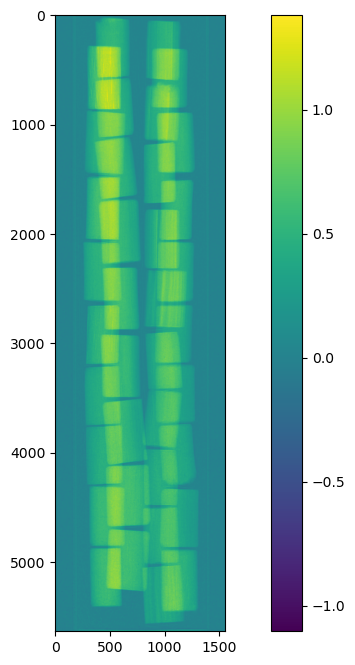

In [6]:
###################### need to change start
idx = 100
###################### need to change end
plt.imshow(proj_mlog_to_recon[idx])
plt.colorbar()
plt.show()

In [ ]:
# Tilt correction (neutompy)
_proj_mlog = proj_mlog_to_recon[:]
proj_mlog_tilt = correction_COR(norm_proj=_proj_mlog, proj_0=_proj_mlog[proj000_idx], proj_180=_proj_mlog[proj180_idx],
                               # shift=-15, theta=0.034688876524931536
                               )
# tt_ang = 'neutompy'
# history_dict = rocku.log(history_dict, 'tilt_corr_use', 'neutompy')

# Reconstruction

Center of rotation 782.0273056030273


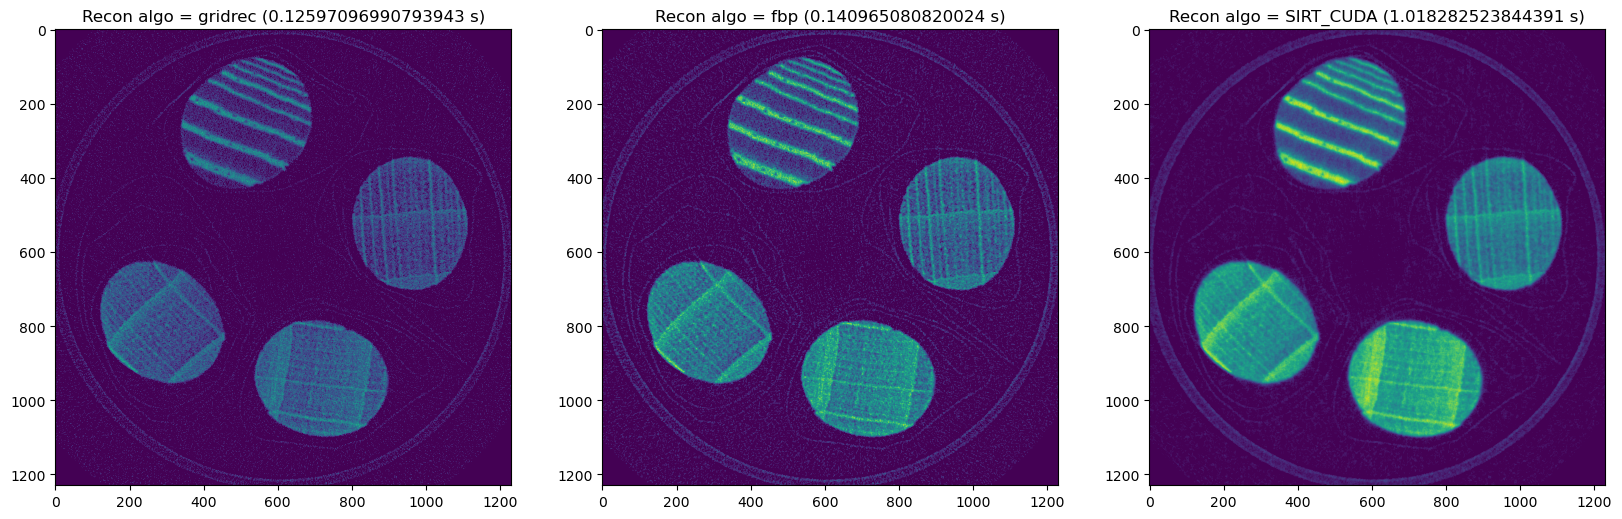

In [14]:
slice_num = None
# slice_num = -110
full_360 = True
# full_360 = False
idx_offset = 20 # adding this many projections past 180 deg if full_360 is False
num_iter = 200 # for iterative recon only
recon_algo_list = ['gridrec',
                   'fbp', 
                   'SIRT_CUDA', 
                   # 'svmbir',
                   ]
rot_center = rot_center_used
#######################
#######################
apply_log = False
if full_360:
    start_ang_idx = proj000_idx
    end_ang_idx = proj360_idx + 1
else:
    start_ang_idx = proj000_idx
    end_ang_idx = proj180_idx + 1 + idx_offset
if slice_num is None:
    slice_num = int(proj_mlog_to_recon.shape[1]/2)
print("Center of rotation", rot_center)
f, ax = plt.subplots(1, len(recon_algo_list), figsize=(20, 20))
for num, each_algo in enumerate(recon_algo_list):
    t0 = timeit.default_timer()
    rec_img1 = rocku.recon_a_slice(sino_mlog_to_recon, proj_mlog_to_recon, slice_num, rot_center, ang_rad, start_ang_idx, end_ang_idx, each_algo, ncore, svmbir_path, num_iter=num_iter, apply_log=apply_log)
    rec_img1 = rocku.crop(rec_img1, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    t1 = timeit.default_timer()
    ax[num].imshow(rec_img1, vmin=0)
    ax[num].set_title('Recon algo = {} ({} s)'.format(each_algo, t1-t0))

In [15]:
recon_algo = 'gridrec'
# recon_algo = 'SIRT_CUDA'
# recon_algo = 'svmbir'
slice_by_slice = False
name_str = None
# name_str = 'test'
# name_str = 'lamino'
############################################################
pix_um = pixel_size_um # um
save_loc = instrument + "/IPTS-"+ipts+"/shared/processed_data/rockit/"
num_proj = len(ang_rad[start_ang_idx:end_ang_idx])
if name_str is not None:
    save_name_str = "_".join([sample_name, name_str, "{}proj".format(num_proj), recon_algo])# + "_roi"
else:
    save_name_str = "_".join([sample_name, "{}proj".format(num_proj), recon_algo])# + "_roi"
save_to = save_loc + save_name_str
##################################
if slice_by_slice:
    rocku.recon_slice_by_slice(sino_mlog_to_recon, proj_mlog_to_recon, rot_center, ang_rad, start_ang_idx, end_ang_idx, recon_algo, ncore, svmbir_path, save_to, recon_crop=recon_crop, recon_crop_roi_dict=recon_crop_roi_dict, pix_um=pix_um, num_iter=num_iter, apply_log=apply_log)
else:
    recon = rocku.recon_full_volume(proj_mlog_to_recon, rot_center, ang_rad, start_ang_idx, end_ang_idx, recon_algo, ncore, svmbir_path, pix_um=pix_um, num_iter=num_iter, apply_log=apply_log)

Time cost 0.6875905124160151 min


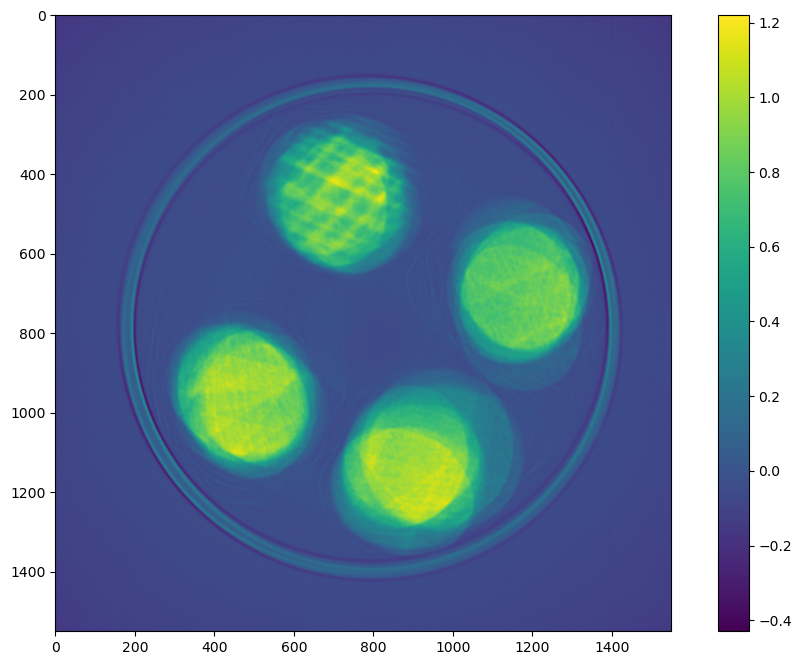

In [16]:
recon_max = np.mean(recon, axis=0)
plt.imshow(recon_max)#, vmax=2)
plt.colorbar()
plt.show()

Recon ROI:


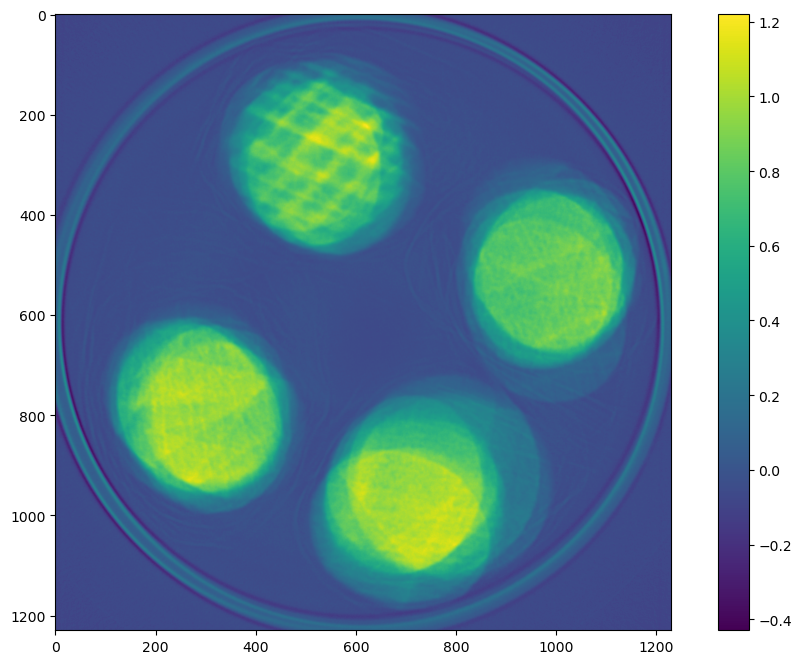

In [17]:
recon_max_crop = rocku.crop(recon_max, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
if recon_crop:
    print("Recon ROI:")
    plt.imshow(recon_max_crop)#, vmax=2)
    plt.colorbar()
    plt.show()

# Export recon files

In [10]:
################ change save path for your own
# Apply cropping to the whole recon volume and save info to h5
recon = rocku.crop(recon, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
num_proj = len(ang_rad[start_ang_idx:end_ang_idx])
_split = sample_name.split('_')
_split.pop(-1)
_sample_name = '_'.join(_split)
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name + "_all"
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + _sample_name + '_' + recon_algo
# save_to = "/netdisk/y9z/IPTS-"+ipts+"/recon/" + sample_name
print(save_to)
dxchange.write_tiff_stack(recon, fname=save_to + "/recon", overwrite=True, digit=4)

/HFIR/CG1D/IPTS-34139/shared/processed_data/rockit/2025_03_07_Tube6_734proj_SIRT_CUDA
